# Exercice 3: Orbit Detection

## Context

The goal of this exercise is to apply a topological approach to a practical problem: the detection of orbits in 2D gravitational simulations.


<img src="data/starship.png" width="240" height="240" align="center"/>

We consider a starship approaching a gravitational system constituted of two moons of different masses. For simplicity, we assume that the two moons are fixed in the referential of our analysis.

During its approach, the starship experiences an engine failure at a position $, and is then only submitted to the gravitational forces induces by the moons.

The question that we pose is the following: What will happen next ? Is the starship starting to orbit around the system ?

To answer this, we propose to launch numerical simulations with different values of $v_{\mathrm{init}}$, the velocity of the starship at $x_{\mathrm{init}}$, and to analyze the results. 


## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd

## Preliminaries
In here we define the functions and parameters needed to compute and display the results of simulations.

In [2]:
# Parameters
m = 1e4 #mass of starship
G = 6.7e-11 #gravitational constant

moon1 = np.array([3e6, 3e6]) #position of moon 1
moon2 = np.array([5e6, 4e6]) #position of moon 2
m1 = 1e22 #mass of moon 1
m2 = 1e23 #mass of moon 2

x_init = np.array([3,2])*1e6 #initial position of starship

# returns the gravitational force induced on an object of mass m
# and position x by an object of mass M and position X
def attraction(x, m, X, M):
    d = np.sqrt((x[0]-X[0])**2 + (x[1]-X[1])**2)
    f = m*M*G * (X-x)/d**3
    return f

def forces(x):
    return attraction(x, m, moon1, m1) + attraction(x, m, moon2, m2)
    

In [3]:
# Simulation parameters
Tf = 3e4  #final time
n = 100000 #number of steps

# Euler semi-implicit scheme to integrate Newton's 2nd law of mechanics.
# Returns a trajectory x as a n x 2 numpy array
# Input: initial velocity v_init (array of size 2)
def solve(v_init):
    x0 = x_init
    v0 = v_init
    
    dt = Tf/n
    t = np.linspace(0, Tf, n)
    
    x = np.zeros((n,2))
    v = np.zeros((n,2))
    
    x[0,:] = x0
    v[0,:] = v0
    for i in range(0,n-1):       
        v[i+1,:] = v[i,:] + dt/m * forces(x[i,:])
        x[i+1,:] = x[i,:] + v[i+1,:] * dt
        
    return x

# Displays the trajectory x
# Inputs: trajectory x (n x 2 array)
#         initial velocity v_init (array of size 2) 
def draw(y, v_init):
    x = y[::20]
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(x[:,0], x[:,1], s=2)

    ax.plot(moon1[0],moon1[1], 'ko', ms=8)
    ax.plot(moon2[0],moon2[1], 'ko', ms=16)

    ax.plot(x_init[0],x_init[1], 'ro', ms=3)
    ax.set_aspect('equal')

    ax.set_xlim(-1e6, 1e7)
    ax.set_ylim(-1e6, 1e7)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

    s=0.001
    if len(v_init)>1:
        ax.annotate("", xy=(x_init[0]+v_init[0]/s, x_init[1]+v_init[1]/s), xytext=(x_init[0], x_init[1]), arrowprops=dict(arrowstyle="->"))
        ax.annotate("v_init=("+"{:.2f}".format(v_init[0])+","+"{:.2f}".format(v_init[1])+")", xytext=(0.2e7, 0.9e7), xy=(0,0))
    plt.show()

## Question 0
In the following code, we define an initial velocity `v_init` as a 2-coordinates vector, then use the function `solve` to generate the corresponding 2d trajectory, and the function `draw` to visualize it. 

Play with several values for `v_init` and observe the resulting trajectories.

In [4]:
v_init = [4000,200]
x = solve(v_init)
# draw(x, v_init)

## Question 1
The goal is to detect initial velocities that result in an **orbit**: a pseudo-periodic trajectory around one or two of the moons.

1) Find a value for `v_init` that results in an orbit.

2) What is the nature of the data (the resulting trajectory) ?

3) What topological feature of the data could characterize the presence of an orbit ? 

4) Use Gudhi to visualize this feature in a **persistence diagram**.

## Question 2: Ensemble analysis
We now deal with an **ensemble** dataset: a collection of 100 trajectories generated with different initial velocities.

1) Load the data, located in `data/trajectories.npy`:

In [5]:
X = np.load("data/trajectories.npy")

The data is stored in a 3-dimensional numpy array where `X[i,:,:]` (for $0\leq i<100$)  gives us the i-th trajectory.

2) Use the function `display` define below to visualize a few of these trajectories. Find the indices of a trajectory that exhibits an orbit, and another one that does not.

In [6]:
# Displays the i-th trajectory
def display(i):
    draw(X[i,:,:], [])

# display(20)

3) For each of the two trajectories, display the persistence diagram. What difference do you observe ?

4) In order to quantify this difference, a distance can be computed between the two diagrams, with Gudhi's `bottleneck_distance` function.
   
Note that the dimension of the diagram has to be specified.

5) What does the following two functions achieve ?

In [7]:
def mystery_function1(min_persistence=0.0):
    pds=[]
    lbl= []
    i=0
    for i,t in enumerate(X):
        t = t[::500,:]
        
        rc = gd.AlphaComplex(points=t)
        st = rc.create_simplex_tree()
        st.compute_persistence()

        pd = st.persistence_intervals_in_dimension(1)
        pd_threshold = [pp for pp in pd if pp[1]-pp[0] > min_persistence]
        
        pds.append(pd_threshold)
        lbl.append(int(len(pd_threshold)))
        
    return pds, lbl

def mystery_function2(pds):
    dm = np.zeros((len(pds), len(pds)))
    for i in range(len(pds)):
        for j in range(i):
            bd = gd.bottleneck_distance(pds[i], pds[j])
            dm[i,j] = dm[j,i] = bd

    return dm

In [8]:
pds, lbl = mystery_function1(1e12)
dm = mystery_function2(pds)

6) We can use Multi-Dimensional Scaling (MDS) to perform an **ensemble visualization** from the topological data we just computed.

In [9]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2, dissimilarity='precomputed')
e = mds.fit_transform(dm)

/home/julius/pyenvs/tda/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


What is represented in the following plot ?

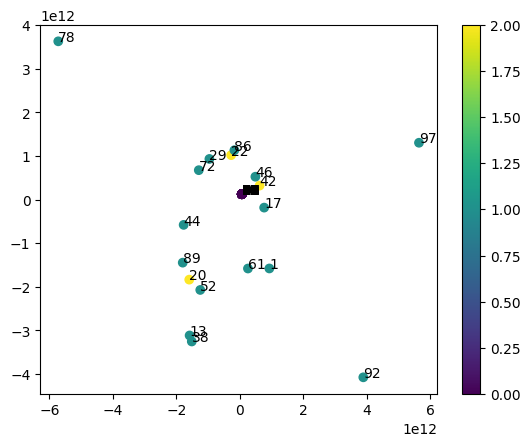

In [10]:
fig_mds = plt.figure()
ax_mds = fig_mds.add_subplot()
scatter = ax_mds.scatter(e[:,0], e[:,1], c=lbl)
N = len(lbl)
for i in range(N):
    ax_mds.annotate(i, (e[i,0], e[i,1]))
plt.colorbar(scatter)

## Question 3
What are the advantages of such a topological approach to ensemble data analysis ?